# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

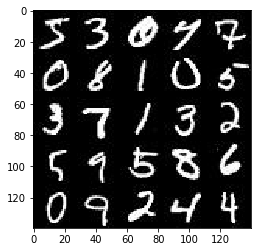

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

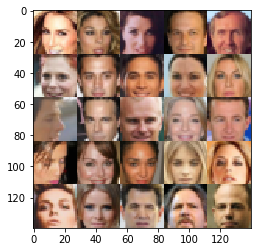

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    learning_rate = tf.placeholder(tf.float32)
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))

    return inputs_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        
        
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2,kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                             padding = 'same')
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2,kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                              padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2,kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                              padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.01
        
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)

        x = tf.layers.conv2d_transpose(x, 256, 5, strides = 2, kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                       padding = 'same')
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.maximum(alpha*x, x)

        x1 = tf.layers.conv2d_transpose(x, 128, 5, strides = 2, kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                        padding = 'same')
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha*x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, out_channel_dim, 5, strides = 1, kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                        padding = 'same')

        out = tf.tanh(x2)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real, reuse = False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse = True)
        
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                                         labels = tf.ones_like(d_out_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                         labels = tf.zeros_like(d_out_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                    labels = tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake
 
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    inputs_real, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate, beta1)
    
    steps = 0
    print_every = 15
    show_every = 120
    losses = []
    n_images = 25    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                z_in = np.random.uniform(-1, 1, (batch_size, z_dim))
                batch_images*= 2.0
                
                _ = sess.run(d_opt, feed_dict = {inputs_real: batch_images, z_input: z_in, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {z_input: z_in,inputs_real: batch_images, lr: learning_rate})
                
                if(steps%print_every == 0):
                    train_loss_d = d_loss.eval({z_input: z_in, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_in})
                    
                    print("epoch: {}/{}...".format(epoch_i+1, epoch_count), 
                          "discriminator loss: {:.4f}...".format(train_loss_d), 
                          "generator loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if(steps%show_every == 0):
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch: 1/2... discriminator loss: 0.3688... generator loss: 3.9896
epoch: 1/2... discriminator loss: 0.4133... generator loss: 3.6196
epoch: 1/2... discriminator loss: 0.4179... generator loss: 2.9800
epoch: 1/2... discriminator loss: 2.0354... generator loss: 0.3372
epoch: 1/2... discriminator loss: 0.6779... generator loss: 1.6697
epoch: 1/2... discriminator loss: 0.8814... generator loss: 1.4326
epoch: 1/2... discriminator loss: 1.1977... generator loss: 1.6570
epoch: 1/2... discriminator loss: 1.5756... generator loss: 0.4519


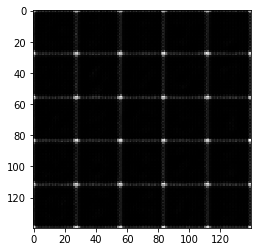

epoch: 1/2... discriminator loss: 1.2313... generator loss: 0.7107
epoch: 1/2... discriminator loss: 1.7872... generator loss: 0.3558
epoch: 1/2... discriminator loss: 1.3097... generator loss: 0.7644
epoch: 1/2... discriminator loss: 1.1175... generator loss: 1.3296
epoch: 1/2... discriminator loss: 1.1788... generator loss: 0.7484
epoch: 1/2... discriminator loss: 1.0081... generator loss: 1.0109
epoch: 1/2... discriminator loss: 1.0087... generator loss: 1.0408
epoch: 1/2... discriminator loss: 1.2527... generator loss: 0.6832


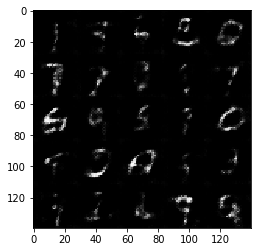

epoch: 1/2... discriminator loss: 1.1515... generator loss: 1.2560
epoch: 1/2... discriminator loss: 0.9667... generator loss: 1.1766
epoch: 1/2... discriminator loss: 1.1183... generator loss: 0.8629
epoch: 1/2... discriminator loss: 1.0070... generator loss: 1.3553
epoch: 1/2... discriminator loss: 1.2607... generator loss: 1.6100
epoch: 1/2... discriminator loss: 1.1268... generator loss: 1.7524
epoch: 1/2... discriminator loss: 1.4642... generator loss: 0.5193
epoch: 1/2... discriminator loss: 1.1353... generator loss: 0.8654


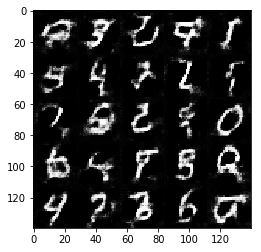

epoch: 1/2... discriminator loss: 1.1911... generator loss: 0.7336
epoch: 1/2... discriminator loss: 1.0616... generator loss: 1.0875
epoch: 1/2... discriminator loss: 1.3214... generator loss: 0.6009
epoch: 1/2... discriminator loss: 1.0354... generator loss: 1.0077
epoch: 1/2... discriminator loss: 1.0345... generator loss: 1.3344
epoch: 1/2... discriminator loss: 0.9797... generator loss: 1.0880
epoch: 1/2... discriminator loss: 1.1562... generator loss: 0.7806
epoch: 1/2... discriminator loss: 1.0859... generator loss: 1.1481


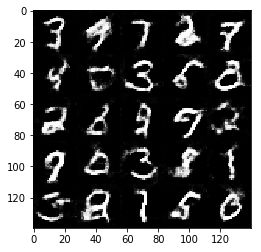

epoch: 1/2... discriminator loss: 1.1930... generator loss: 0.7962
epoch: 1/2... discriminator loss: 1.0867... generator loss: 1.0171
epoch: 1/2... discriminator loss: 1.1982... generator loss: 1.7886
epoch: 1/2... discriminator loss: 1.1097... generator loss: 0.8990
epoch: 1/2... discriminator loss: 1.1130... generator loss: 0.9521
epoch: 1/2... discriminator loss: 1.3284... generator loss: 0.5998
epoch: 1/2... discriminator loss: 1.0789... generator loss: 1.2366
epoch: 1/2... discriminator loss: 1.0162... generator loss: 1.0127


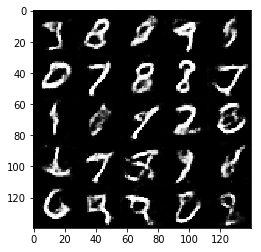

epoch: 1/2... discriminator loss: 1.2655... generator loss: 0.5976
epoch: 1/2... discriminator loss: 1.0828... generator loss: 1.0138
epoch: 1/2... discriminator loss: 1.0618... generator loss: 0.9287
epoch: 1/2... discriminator loss: 1.1099... generator loss: 0.8882
epoch: 1/2... discriminator loss: 1.0992... generator loss: 1.7149
epoch: 1/2... discriminator loss: 1.0255... generator loss: 0.9465
epoch: 1/2... discriminator loss: 1.2250... generator loss: 0.6583
epoch: 1/2... discriminator loss: 1.1305... generator loss: 0.8025


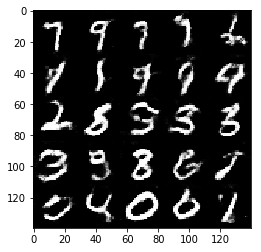

epoch: 1/2... discriminator loss: 1.0164... generator loss: 1.8652
epoch: 1/2... discriminator loss: 1.1303... generator loss: 0.8091
epoch: 1/2... discriminator loss: 0.9866... generator loss: 1.3793
epoch: 1/2... discriminator loss: 1.6480... generator loss: 0.3967
epoch: 1/2... discriminator loss: 1.2136... generator loss: 0.6671
epoch: 1/2... discriminator loss: 1.1294... generator loss: 0.7744
epoch: 1/2... discriminator loss: 1.0080... generator loss: 1.2126
epoch: 1/2... discriminator loss: 0.9209... generator loss: 1.7838


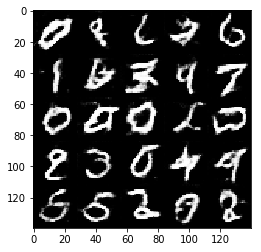

epoch: 1/2... discriminator loss: 0.8919... generator loss: 1.1938
epoch: 1/2... discriminator loss: 1.3163... generator loss: 0.8297
epoch: 1/2... discriminator loss: 1.1250... generator loss: 1.2013
epoch: 1/2... discriminator loss: 0.9726... generator loss: 1.1166
epoch: 1/2... discriminator loss: 1.2282... generator loss: 0.6621
epoch: 1/2... discriminator loss: 1.0863... generator loss: 1.0149
epoch: 2/2... discriminator loss: 1.1801... generator loss: 0.8848
epoch: 2/2... discriminator loss: 1.0687... generator loss: 0.8353


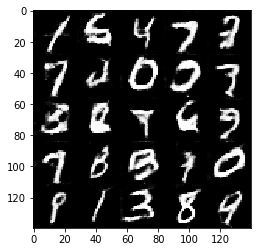

epoch: 2/2... discriminator loss: 0.9111... generator loss: 1.0890
epoch: 2/2... discriminator loss: 1.3339... generator loss: 0.5996
epoch: 2/2... discriminator loss: 1.0489... generator loss: 0.8872
epoch: 2/2... discriminator loss: 0.9957... generator loss: 1.0784
epoch: 2/2... discriminator loss: 1.2940... generator loss: 0.5844
epoch: 2/2... discriminator loss: 0.9911... generator loss: 1.0948
epoch: 2/2... discriminator loss: 1.3503... generator loss: 0.5759
epoch: 2/2... discriminator loss: 1.1967... generator loss: 0.6973


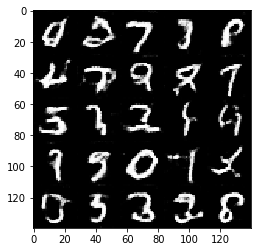

epoch: 2/2... discriminator loss: 0.9320... generator loss: 1.1013
epoch: 2/2... discriminator loss: 1.1289... generator loss: 0.8035
epoch: 2/2... discriminator loss: 1.0402... generator loss: 0.9922
epoch: 2/2... discriminator loss: 0.9778... generator loss: 0.9389
epoch: 2/2... discriminator loss: 0.9961... generator loss: 1.0682
epoch: 2/2... discriminator loss: 0.9138... generator loss: 1.3378
epoch: 2/2... discriminator loss: 0.9826... generator loss: 1.3071
epoch: 2/2... discriminator loss: 1.1206... generator loss: 0.7523


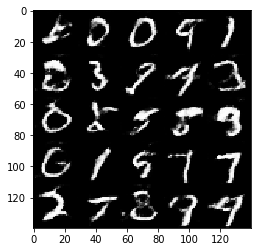

epoch: 2/2... discriminator loss: 0.9563... generator loss: 1.2868
epoch: 2/2... discriminator loss: 0.9603... generator loss: 1.1267
epoch: 2/2... discriminator loss: 1.0593... generator loss: 0.7837
epoch: 2/2... discriminator loss: 1.0542... generator loss: 1.9068
epoch: 2/2... discriminator loss: 0.9140... generator loss: 1.1931
epoch: 2/2... discriminator loss: 0.9320... generator loss: 1.2899
epoch: 2/2... discriminator loss: 0.9428... generator loss: 1.5359
epoch: 2/2... discriminator loss: 1.1144... generator loss: 1.1683


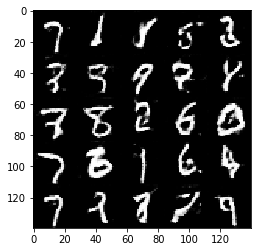

epoch: 2/2... discriminator loss: 1.1551... generator loss: 0.7393
epoch: 2/2... discriminator loss: 1.6313... generator loss: 0.4291
epoch: 2/2... discriminator loss: 1.2557... generator loss: 0.8477
epoch: 2/2... discriminator loss: 1.0770... generator loss: 0.8204
epoch: 2/2... discriminator loss: 1.2721... generator loss: 0.6523
epoch: 2/2... discriminator loss: 1.2254... generator loss: 0.6086
epoch: 2/2... discriminator loss: 1.0824... generator loss: 0.8915
epoch: 2/2... discriminator loss: 0.8219... generator loss: 1.2522


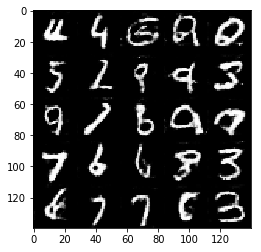

epoch: 2/2... discriminator loss: 1.1641... generator loss: 0.7193
epoch: 2/2... discriminator loss: 1.0397... generator loss: 1.0315
epoch: 2/2... discriminator loss: 0.8332... generator loss: 1.3236
epoch: 2/2... discriminator loss: 0.8077... generator loss: 1.2873
epoch: 2/2... discriminator loss: 0.8523... generator loss: 1.2972
epoch: 2/2... discriminator loss: 0.7167... generator loss: 1.5587
epoch: 2/2... discriminator loss: 1.1760... generator loss: 1.1988
epoch: 2/2... discriminator loss: 0.8987... generator loss: 1.6206


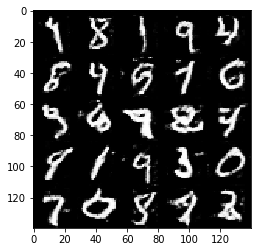

epoch: 2/2... discriminator loss: 0.9893... generator loss: 1.0286
epoch: 2/2... discriminator loss: 1.4655... generator loss: 0.4932
epoch: 2/2... discriminator loss: 1.0291... generator loss: 0.8369
epoch: 2/2... discriminator loss: 0.9505... generator loss: 1.2113
epoch: 2/2... discriminator loss: 0.9687... generator loss: 1.2081
epoch: 2/2... discriminator loss: 2.7598... generator loss: 0.2005
epoch: 2/2... discriminator loss: 0.9350... generator loss: 1.1630
epoch: 2/2... discriminator loss: 0.9094... generator loss: 1.2647


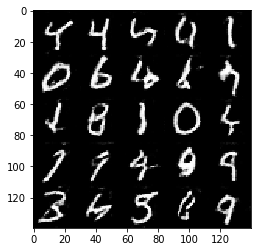

epoch: 2/2... discriminator loss: 0.8249... generator loss: 1.6160
epoch: 2/2... discriminator loss: 0.9150... generator loss: 1.8564
epoch: 2/2... discriminator loss: 1.1146... generator loss: 0.7771
epoch: 2/2... discriminator loss: 0.8420... generator loss: 1.5629
epoch: 2/2... discriminator loss: 0.9449... generator loss: 1.6549
epoch: 2/2... discriminator loss: 0.9012... generator loss: 1.7298
epoch: 2/2... discriminator loss: 1.7115... generator loss: 0.3618
epoch: 2/2... discriminator loss: 1.3017... generator loss: 0.8469


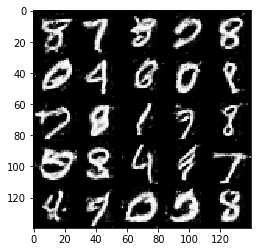

epoch: 2/2... discriminator loss: 0.8247... generator loss: 1.3575
epoch: 2/2... discriminator loss: 1.0926... generator loss: 0.8243
epoch: 2/2... discriminator loss: 0.9544... generator loss: 1.1243
epoch: 2/2... discriminator loss: 0.8934... generator loss: 1.1195


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch: 1/1... discriminator loss: 0.3820... generator loss: 4.4352
epoch: 1/1... discriminator loss: 0.3806... generator loss: 4.4247
epoch: 1/1... discriminator loss: 0.4245... generator loss: 5.0478
epoch: 1/1... discriminator loss: 0.6319... generator loss: 3.0548
epoch: 1/1... discriminator loss: 2.6622... generator loss: 0.1540
epoch: 1/1... discriminator loss: 0.8679... generator loss: 1.3809
epoch: 1/1... discriminator loss: 0.6613... generator loss: 1.9836
epoch: 1/1... discriminator loss: 0.3886... generator loss: 4.7383


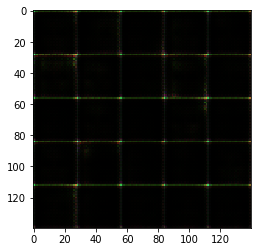

epoch: 1/1... discriminator loss: 0.4399... generator loss: 2.9834
epoch: 1/1... discriminator loss: 0.6016... generator loss: 6.0244
epoch: 1/1... discriminator loss: 0.3835... generator loss: 5.4805
epoch: 1/1... discriminator loss: 0.8398... generator loss: 1.1930
epoch: 1/1... discriminator loss: 1.5610... generator loss: 0.7041
epoch: 1/1... discriminator loss: 0.6488... generator loss: 1.7414
epoch: 1/1... discriminator loss: 1.1654... generator loss: 1.3038
epoch: 1/1... discriminator loss: 0.8684... generator loss: 1.5606


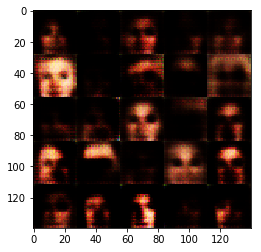

epoch: 1/1... discriminator loss: 0.6511... generator loss: 4.5117
epoch: 1/1... discriminator loss: 1.0818... generator loss: 0.8436
epoch: 1/1... discriminator loss: 1.2548... generator loss: 0.6373
epoch: 1/1... discriminator loss: 1.1144... generator loss: 3.6612
epoch: 1/1... discriminator loss: 1.0237... generator loss: 1.0545
epoch: 1/1... discriminator loss: 1.4297... generator loss: 2.2341
epoch: 1/1... discriminator loss: 1.1039... generator loss: 1.6440
epoch: 1/1... discriminator loss: 1.2433... generator loss: 0.6937


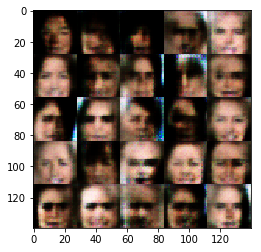

epoch: 1/1... discriminator loss: 1.9315... generator loss: 0.2971
epoch: 1/1... discriminator loss: 1.1329... generator loss: 0.7289
epoch: 1/1... discriminator loss: 0.7797... generator loss: 1.3916
epoch: 1/1... discriminator loss: 1.3675... generator loss: 0.5516
epoch: 1/1... discriminator loss: 0.9054... generator loss: 1.1615
epoch: 1/1... discriminator loss: 0.6331... generator loss: 1.6671
epoch: 1/1... discriminator loss: 1.3367... generator loss: 3.2822
epoch: 1/1... discriminator loss: 1.5437... generator loss: 0.4699


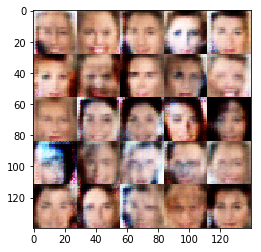

epoch: 1/1... discriminator loss: 1.2111... generator loss: 1.4197
epoch: 1/1... discriminator loss: 1.0518... generator loss: 0.9372
epoch: 1/1... discriminator loss: 1.1731... generator loss: 0.7910
epoch: 1/1... discriminator loss: 1.2825... generator loss: 0.6026
epoch: 1/1... discriminator loss: 0.6879... generator loss: 3.1437
epoch: 1/1... discriminator loss: 2.1213... generator loss: 0.2174
epoch: 1/1... discriminator loss: 1.0794... generator loss: 1.1828
epoch: 1/1... discriminator loss: 1.2096... generator loss: 1.3644


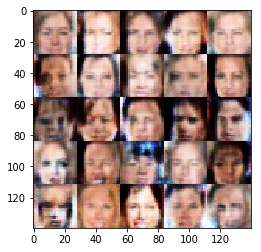

epoch: 1/1... discriminator loss: 1.0522... generator loss: 0.9438
epoch: 1/1... discriminator loss: 0.9807... generator loss: 2.1013
epoch: 1/1... discriminator loss: 1.0818... generator loss: 1.7790
epoch: 1/1... discriminator loss: 1.3785... generator loss: 0.5176
epoch: 1/1... discriminator loss: 1.2055... generator loss: 0.7996
epoch: 1/1... discriminator loss: 1.8316... generator loss: 0.3052
epoch: 1/1... discriminator loss: 1.1920... generator loss: 0.9856
epoch: 1/1... discriminator loss: 0.7830... generator loss: 1.4796


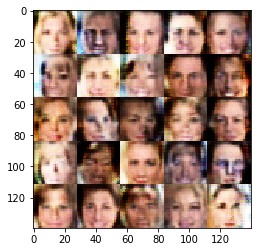

epoch: 1/1... discriminator loss: 1.0402... generator loss: 0.9127
epoch: 1/1... discriminator loss: 1.1985... generator loss: 0.6701
epoch: 1/1... discriminator loss: 1.2224... generator loss: 1.1487
epoch: 1/1... discriminator loss: 1.2715... generator loss: 0.8521
epoch: 1/1... discriminator loss: 0.8733... generator loss: 1.4088
epoch: 1/1... discriminator loss: 1.3677... generator loss: 0.9344
epoch: 1/1... discriminator loss: 1.2237... generator loss: 0.9552
epoch: 1/1... discriminator loss: 1.3682... generator loss: 0.5226


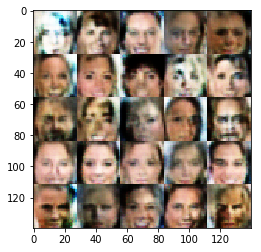

epoch: 1/1... discriminator loss: 1.0919... generator loss: 1.2340
epoch: 1/1... discriminator loss: 0.7281... generator loss: 1.4540
epoch: 1/1... discriminator loss: 0.4473... generator loss: 3.8316
epoch: 1/1... discriminator loss: 1.7567... generator loss: 0.3269
epoch: 1/1... discriminator loss: 1.1102... generator loss: 0.8043
epoch: 1/1... discriminator loss: 1.2807... generator loss: 0.6539
epoch: 1/1... discriminator loss: 1.1570... generator loss: 1.0987
epoch: 1/1... discriminator loss: 1.3592... generator loss: 0.6953


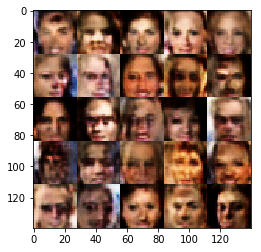

epoch: 1/1... discriminator loss: 0.8859... generator loss: 2.8157
epoch: 1/1... discriminator loss: 1.3830... generator loss: 0.5382
epoch: 1/1... discriminator loss: 1.0704... generator loss: 1.3606
epoch: 1/1... discriminator loss: 0.7140... generator loss: 1.7091
epoch: 1/1... discriminator loss: 1.0806... generator loss: 0.8139
epoch: 1/1... discriminator loss: 1.2538... generator loss: 0.7113
epoch: 1/1... discriminator loss: 1.2027... generator loss: 0.7738
epoch: 1/1... discriminator loss: 1.0997... generator loss: 0.7113


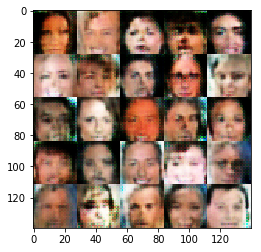

epoch: 1/1... discriminator loss: 1.3833... generator loss: 0.6380
epoch: 1/1... discriminator loss: 1.3790... generator loss: 0.5802
epoch: 1/1... discriminator loss: 2.1550... generator loss: 0.1952
epoch: 1/1... discriminator loss: 1.0412... generator loss: 0.9777
epoch: 1/1... discriminator loss: 0.8192... generator loss: 1.9114
epoch: 1/1... discriminator loss: 0.9130... generator loss: 0.9937
epoch: 1/1... discriminator loss: 0.7501... generator loss: 1.4646
epoch: 1/1... discriminator loss: 1.0105... generator loss: 1.0909


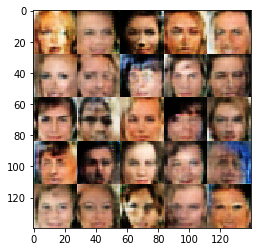

epoch: 1/1... discriminator loss: 1.4294... generator loss: 3.4920
epoch: 1/1... discriminator loss: 0.7101... generator loss: 2.3931
epoch: 1/1... discriminator loss: 1.4339... generator loss: 0.4775
epoch: 1/1... discriminator loss: 1.1519... generator loss: 0.6899
epoch: 1/1... discriminator loss: 1.4299... generator loss: 0.4916
epoch: 1/1... discriminator loss: 1.1799... generator loss: 1.2988
epoch: 1/1... discriminator loss: 1.3721... generator loss: 0.5248
epoch: 1/1... discriminator loss: 1.1445... generator loss: 1.2666


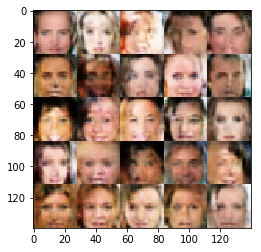

epoch: 1/1... discriminator loss: 1.4370... generator loss: 0.4630
epoch: 1/1... discriminator loss: 1.2204... generator loss: 0.6882
epoch: 1/1... discriminator loss: 0.7555... generator loss: 1.9950
epoch: 1/1... discriminator loss: 1.3708... generator loss: 1.2713
epoch: 1/1... discriminator loss: 2.1125... generator loss: 0.2175
epoch: 1/1... discriminator loss: 1.9773... generator loss: 0.2412
epoch: 1/1... discriminator loss: 1.2879... generator loss: 0.6554
epoch: 1/1... discriminator loss: 1.3496... generator loss: 0.5406


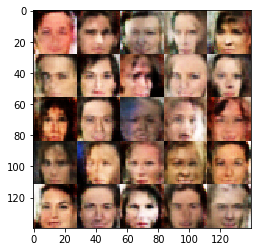

epoch: 1/1... discriminator loss: 1.4627... generator loss: 0.4851
epoch: 1/1... discriminator loss: 1.1823... generator loss: 1.1933
epoch: 1/1... discriminator loss: 1.2276... generator loss: 0.6633
epoch: 1/1... discriminator loss: 1.3607... generator loss: 1.0788
epoch: 1/1... discriminator loss: 1.5132... generator loss: 1.7359
epoch: 1/1... discriminator loss: 0.9015... generator loss: 1.2663
epoch: 1/1... discriminator loss: 1.1652... generator loss: 1.1731
epoch: 1/1... discriminator loss: 1.0654... generator loss: 2.7252


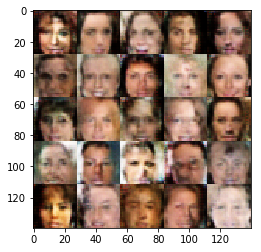

epoch: 1/1... discriminator loss: 1.6106... generator loss: 0.3765
epoch: 1/1... discriminator loss: 1.1582... generator loss: 0.6983
epoch: 1/1... discriminator loss: 1.3556... generator loss: 2.7244
epoch: 1/1... discriminator loss: 1.1957... generator loss: 1.0305
epoch: 1/1... discriminator loss: 1.4941... generator loss: 0.5336
epoch: 1/1... discriminator loss: 1.3570... generator loss: 0.5536
epoch: 1/1... discriminator loss: 1.2168... generator loss: 0.8488
epoch: 1/1... discriminator loss: 1.3232... generator loss: 0.6408


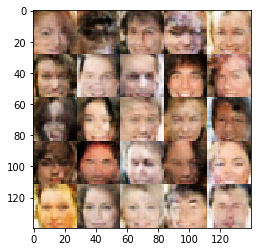

epoch: 1/1... discriminator loss: 1.2301... generator loss: 1.0244
epoch: 1/1... discriminator loss: 1.3680... generator loss: 0.8602
epoch: 1/1... discriminator loss: 1.1963... generator loss: 1.0746
epoch: 1/1... discriminator loss: 1.2230... generator loss: 0.7293
epoch: 1/1... discriminator loss: 0.9769... generator loss: 1.3668
epoch: 1/1... discriminator loss: 1.2661... generator loss: 0.6309
epoch: 1/1... discriminator loss: 1.4665... generator loss: 0.4726
epoch: 1/1... discriminator loss: 1.3197... generator loss: 0.5737


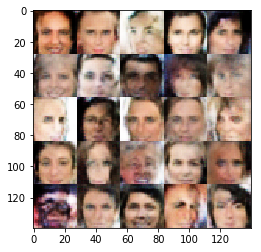

epoch: 1/1... discriminator loss: 1.6126... generator loss: 1.0237
epoch: 1/1... discriminator loss: 1.2177... generator loss: 0.9938
epoch: 1/1... discriminator loss: 1.0902... generator loss: 1.1739
epoch: 1/1... discriminator loss: 2.0160... generator loss: 0.2473
epoch: 1/1... discriminator loss: 1.1461... generator loss: 0.7836
epoch: 1/1... discriminator loss: 1.2682... generator loss: 1.0179
epoch: 1/1... discriminator loss: 1.2953... generator loss: 0.5942
epoch: 1/1... discriminator loss: 1.0832... generator loss: 1.0805


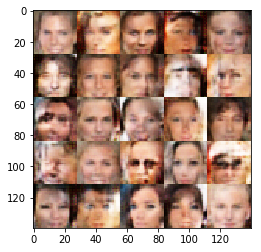

epoch: 1/1... discriminator loss: 1.2303... generator loss: 1.0699
epoch: 1/1... discriminator loss: 1.3633... generator loss: 0.5911
epoch: 1/1... discriminator loss: 1.4764... generator loss: 0.5065
epoch: 1/1... discriminator loss: 1.3294... generator loss: 0.8317
epoch: 1/1... discriminator loss: 1.6547... generator loss: 0.3876
epoch: 1/1... discriminator loss: 1.2822... generator loss: 0.5946
epoch: 1/1... discriminator loss: 1.3062... generator loss: 0.7586
epoch: 1/1... discriminator loss: 1.4101... generator loss: 1.2851


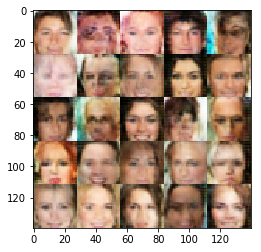

epoch: 1/1... discriminator loss: 0.9053... generator loss: 1.1895
epoch: 1/1... discriminator loss: 1.8133... generator loss: 0.2957
epoch: 1/1... discriminator loss: 1.1603... generator loss: 0.7311
epoch: 1/1... discriminator loss: 1.2092... generator loss: 0.7268
epoch: 1/1... discriminator loss: 1.1743... generator loss: 0.7651
epoch: 1/1... discriminator loss: 1.1361... generator loss: 0.6988
epoch: 1/1... discriminator loss: 1.3682... generator loss: 0.6128
epoch: 1/1... discriminator loss: 1.4020... generator loss: 0.5132


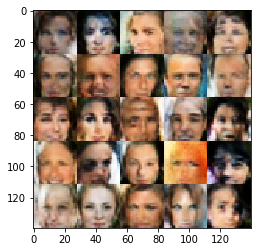

epoch: 1/1... discriminator loss: 1.1662... generator loss: 1.0736
epoch: 1/1... discriminator loss: 1.1155... generator loss: 0.8054
epoch: 1/1... discriminator loss: 1.3111... generator loss: 0.9195
epoch: 1/1... discriminator loss: 1.5646... generator loss: 0.4229
epoch: 1/1... discriminator loss: 1.2781... generator loss: 0.8432
epoch: 1/1... discriminator loss: 1.2722... generator loss: 0.8631
epoch: 1/1... discriminator loss: 1.1766... generator loss: 0.8303
epoch: 1/1... discriminator loss: 1.5740... generator loss: 0.4315


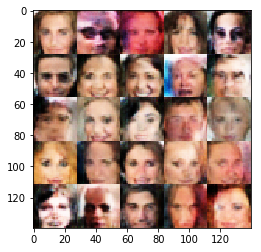

epoch: 1/1... discriminator loss: 1.3389... generator loss: 0.7003
epoch: 1/1... discriminator loss: 1.2790... generator loss: 0.7553
epoch: 1/1... discriminator loss: 1.3862... generator loss: 0.5321
epoch: 1/1... discriminator loss: 1.0955... generator loss: 1.3367
epoch: 1/1... discriminator loss: 1.3146... generator loss: 1.2902
epoch: 1/1... discriminator loss: 1.4064... generator loss: 0.5271
epoch: 1/1... discriminator loss: 1.7873... generator loss: 0.3299
epoch: 1/1... discriminator loss: 1.6008... generator loss: 0.4040


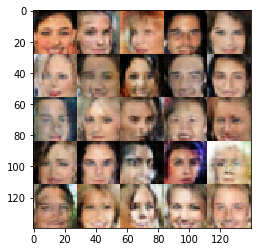

epoch: 1/1... discriminator loss: 0.8768... generator loss: 1.2527
epoch: 1/1... discriminator loss: 1.3519... generator loss: 1.1266
epoch: 1/1... discriminator loss: 1.3119... generator loss: 0.7118
epoch: 1/1... discriminator loss: 1.3122... generator loss: 0.7255
epoch: 1/1... discriminator loss: 1.4475... generator loss: 0.8019
epoch: 1/1... discriminator loss: 1.4420... generator loss: 0.7195
epoch: 1/1... discriminator loss: 1.5432... generator loss: 0.4937
epoch: 1/1... discriminator loss: 1.3551... generator loss: 0.5995


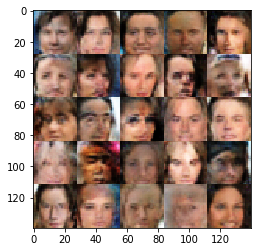

epoch: 1/1... discriminator loss: 1.3604... generator loss: 0.6386
epoch: 1/1... discriminator loss: 1.5363... generator loss: 0.7853
epoch: 1/1... discriminator loss: 1.3904... generator loss: 0.6813
epoch: 1/1... discriminator loss: 1.4124... generator loss: 0.5874
epoch: 1/1... discriminator loss: 1.2150... generator loss: 1.3914
epoch: 1/1... discriminator loss: 1.3599... generator loss: 0.7818
epoch: 1/1... discriminator loss: 1.3572... generator loss: 0.7183
epoch: 1/1... discriminator loss: 1.4618... generator loss: 0.5674


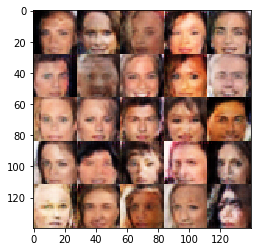

epoch: 1/1... discriminator loss: 1.4264... generator loss: 0.7467
epoch: 1/1... discriminator loss: 1.3931... generator loss: 0.6586
epoch: 1/1... discriminator loss: 1.2735... generator loss: 0.7490
epoch: 1/1... discriminator loss: 1.2738... generator loss: 0.7561
epoch: 1/1... discriminator loss: 1.3134... generator loss: 0.9854
epoch: 1/1... discriminator loss: 1.6473... generator loss: 0.4058
epoch: 1/1... discriminator loss: 1.2655... generator loss: 0.8042
epoch: 1/1... discriminator loss: 1.4910... generator loss: 0.5572


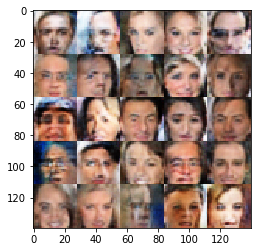

epoch: 1/1... discriminator loss: 1.2832... generator loss: 0.9509
epoch: 1/1... discriminator loss: 1.5134... generator loss: 0.5544
epoch: 1/1... discriminator loss: 1.2725... generator loss: 0.6832
epoch: 1/1... discriminator loss: 1.1555... generator loss: 0.8500
epoch: 1/1... discriminator loss: 1.3921... generator loss: 0.5991
epoch: 1/1... discriminator loss: 1.3908... generator loss: 0.7626
epoch: 1/1... discriminator loss: 1.3416... generator loss: 0.5955
epoch: 1/1... discriminator loss: 1.4642... generator loss: 0.9673


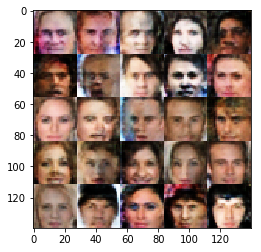

epoch: 1/1... discriminator loss: 1.3120... generator loss: 0.7591
epoch: 1/1... discriminator loss: 1.5190... generator loss: 0.8044
epoch: 1/1... discriminator loss: 1.4605... generator loss: 0.4962
epoch: 1/1... discriminator loss: 1.2475... generator loss: 0.8636
epoch: 1/1... discriminator loss: 1.3514... generator loss: 0.6969
epoch: 1/1... discriminator loss: 1.3547... generator loss: 0.6474
epoch: 1/1... discriminator loss: 1.3950... generator loss: 0.6093
epoch: 1/1... discriminator loss: 1.3172... generator loss: 0.5576


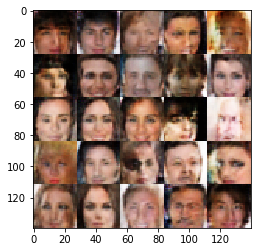

epoch: 1/1... discriminator loss: 1.0503... generator loss: 1.0737
epoch: 1/1... discriminator loss: 1.3676... generator loss: 0.7043
epoch: 1/1... discriminator loss: 1.3163... generator loss: 0.6825
epoch: 1/1... discriminator loss: 1.4010... generator loss: 0.6815
epoch: 1/1... discriminator loss: 1.2760... generator loss: 0.6914
epoch: 1/1... discriminator loss: 1.2877... generator loss: 0.7158
epoch: 1/1... discriminator loss: 1.3616... generator loss: 0.7210
epoch: 1/1... discriminator loss: 1.3663... generator loss: 0.7092


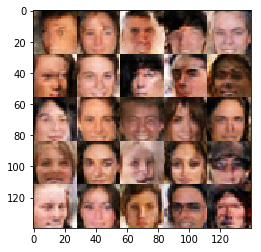

epoch: 1/1... discriminator loss: 1.2496... generator loss: 0.7104
epoch: 1/1... discriminator loss: 1.3841... generator loss: 0.6662
epoch: 1/1... discriminator loss: 1.3593... generator loss: 0.5665


In [19]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.